## Solution Model
### XGBoost Regression Model for Seismic Magnitude Prediction

The workflow includes:
- Data preprocessing
- Feature importance
- Hyperparameter tuning using Optuna
- Stratified K fold cross-validation based on clusters
- Final model evaluation on a test set
- Visualization of model performance

#### 1. Importing necessary libraries

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
sns.set(style='whitegrid', context='notebook')

C:\Users\alapati.chandana\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. Loading the dataset

In [2]:
df = pd.read_excel("merged_data(837).xlsx")

#### 3. Data understanding

In [3]:
print(df.head())

      X       Y               Date/Time  Magnitude Cluster  \
0  8009  104070 2017-09-05 01:27:55.400       -2.1     C-5   
1  7728  104155 2017-09-25 16:38:05.000       -1.4     C-6   
2  6712  104286 2017-10-02 09:48:25.600       -1.6     C-6   
3  7649  104192 2017-10-07 13:32:05.700       -2.1     C-6   
4  7683  104270 2017-10-08 05:23:34.000       -2.1     C-6   

           Event_Hour                Time Drill Centre Well_Name  \
0 2017-09-05 01:00:00 2017-09-05 01:00:00            C        W7   
1 2017-09-25 16:00:00 2017-09-25 16:00:00            B        W3   
2 2017-10-02 09:00:00 2017-10-02 09:00:00            B        W6   
3 2017-10-07 13:00:00 2017-10-07 13:00:00            C        W7   
4 2017-10-08 05:00:00 2017-10-08 05:00:00            A        W1   

       BHP.kPag   BHT.degC  CO2 Injection Rate (kg/s)  Cumm Inj (Tonnes)  
0  21420.426006  74.307625                  10.000603       15662.870970  
1  20918.519531  98.169998                   0.000000        6573.30

In [4]:
print(df.shape)

(837, 13)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   X                          837 non-null    int64         
 1   Y                          837 non-null    int64         
 2   Date/Time                  837 non-null    datetime64[ns]
 3   Magnitude                  837 non-null    float64       
 4   Cluster                    837 non-null    object        
 5   Event_Hour                 837 non-null    datetime64[ns]
 6   Time                       837 non-null    datetime64[ns]
 7   Drill Centre               837 non-null    object        
 8   Well_Name                  837 non-null    object        
 9   BHP.kPag                   837 non-null    float64       
 10  BHT.degC                   837 non-null    float64       
 11  CO2 Injection Rate (kg/s)  837 non-null    float64       
 12  Cumm Inj

In [6]:
print(df.describe())

                  X              Y                      Date/Time   Magnitude  \
count    837.000000     837.000000                            837  837.000000   
mean    8256.796894  104858.544803  2018-04-06 19:47:46.549223680   -1.311470   
min     5120.000000   99000.000000     2017-09-05 01:27:55.400000   -2.300000   
25%     7510.000000  104166.000000     2018-03-05 22:22:54.200000   -1.600000   
50%     8134.000000  104720.000000     2018-04-14 09:33:49.300000   -1.400000   
75%     8600.000000  105369.000000     2018-05-22 09:03:18.600000   -1.100000   
max    13720.000000  109410.000000     2018-07-14 01:00:23.200000    1.100000   
std     1327.838626    1088.877922                            NaN    0.475286   

                          Event_Hour                           Time  \
count                            837                            837   
mean   2018-04-06 19:18:08.172042752  2018-04-06 19:18:08.172042752   
min              2017-09-05 01:00:00            2017-09-0

#### 3. Data Cleaning

In [7]:
# Checking the null values
df.isnull().sum()

X                            0
Y                            0
Date/Time                    0
Magnitude                    0
Cluster                      0
Event_Hour                   0
Time                         0
Drill Centre                 0
Well_Name                    0
BHP.kPag                     0
BHT.degC                     0
CO2 Injection Rate (kg/s)    0
Cumm Inj (Tonnes)            0
dtype: int64

In [8]:
# Checking if there are any duplicated values
df.duplicated().sum()

np.int64(0)

In [9]:
# Convert Date/Time to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

#### 4. Identifying numerical and categorical features

In [11]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
datetime_features = df.select_dtypes(include=["datetime64"]).columns
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("Datetime:", datetime_features)


Numeric: ['X', 'Y', 'Magnitude', 'BHP.kPag', 'BHT.degC', 'CO2 Injection Rate (kg/s)', 'Cumm Inj (Tonnes)']
Categorical: ['Cluster', 'Drill Centre', 'Well_Name']
Datetime: Index(['Date/Time', 'Event_Hour', 'Time'], dtype='object')


#### 5. Feature selection and target variable

In [12]:
target= 'Magnitude'

In [13]:
# Features 
X = df[['X','Y','BHP.kPag','BHT.degC', 'CO2 Injection Rate (kg/s)','Cumm Inj (Tonnes)']]
y = df[target]

#### 6. Baseline XGBOOST model
Before hyperparameter tuning, a baseline XGBoost regression model is trained using default parameters. This provides a reference point to evaluate the impact of hyperparameter optimization.

In [41]:
# splitting the data into 80-20%
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42  # ensures reproducibility
)

In [42]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
xgb_baseline = xgb.XGBRegressor(
    objective='reg:squarederror',  # regression
    random_state=42
)
xgb_baseline.fit(X_train, y_train)
y_pred = xgb_baseline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Baseline RMSE: {rmse:.4f}")
print(f"Baseline R²: {r2:.4f}")


Baseline RMSE: 0.3342
Baseline R²: 0.5211


#### 7. Feature Importance

In [16]:
baseline_model = xgb_baseline

# Feature names
feature_names = X_train.columns

# Extract feature importance
importances = baseline_model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,X,0.407100
1,Y,0.321569
4,CO2 Injection Rate (kg/s),0.082694
3,BHT.degC,0.066767
5,Cumm Inj (Tonnes),0.063005
2,BHP.kPag,0.058865


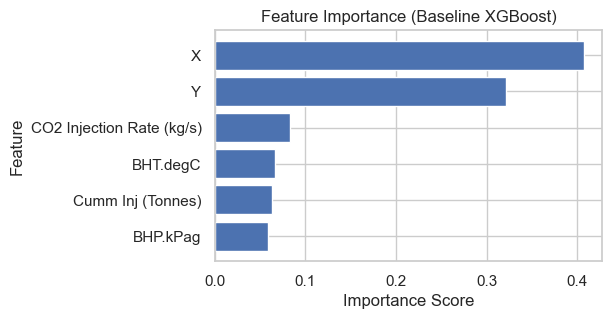

In [18]:
plt.figure(figsize=(5,3))
plt.barh(
    feature_importance_df['Feature'],
    feature_importance_df['Importance']
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Baseline XGBoost)")
plt.gca().invert_yaxis()
plt.show()

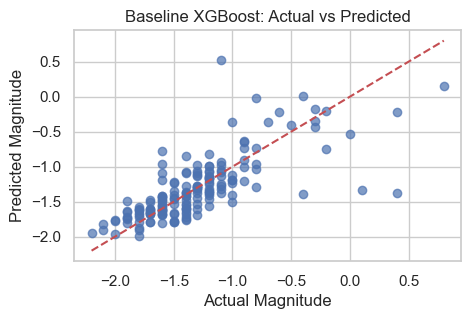

In [21]:
plt.figure(figsize=(5,3))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Baseline XGBoost: Actual vs Predicted")
plt.grid(True)
plt.show()

- The baseline model provides a benchmark, showing that XGBoost is capable of capturing non-linear relationships in the data. 
- Hyperparameter tuning further improves predictive performance. 


#### 7. Stratified K-Fold Cross-Validation and HyperParameter Tuning 
- To ensure that data from all geological clusters is fairly represented during
model training and validation, Stratified K-Fold cross-validation is used based
on the  variable.

- Hyperparameter tuning is performed using Optuna, which explores different
combinations of XGBoost parameters. Model performance is evaluated using the
average R² score across all folds.

In [24]:
# Stratify on Cluster
clusters = df['Cluster']
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0)
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    for train_idx, val_idx in skf.split(X, clusters):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', xgb.XGBRegressor(
                objective='reg:squarederror',
                random_state=42,
                n_jobs=-1,
                **params
            ))
        ])
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        r2_scores.append(r2_score(y_val, preds))
    # save R2 inside trial
    trial.set_user_attr("mean_r2", np.mean(r2_scores))
    # Optuna still needs a value → return RMSE
    return -np.mean(r2_scores)  # maximize R2 indirectly

Optuna is used to automatically search for the best set of hyperparameters that
maximize the model’s predictive performance. Each trial is evaluated using
Stratified K-Fold cross-validation, and the objective is to maximize the mean
R² score across folds.

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print("Best R2:", study.best_trial.user_attrs["mean_r2"])

[I 2025-12-17 18:30:47,738] A new study created in memory with name: no-name-45975909-301f-450f-a60a-424a1714aa57
C:\Users\alapati.chandana\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-12-17 18:30:48,704] Trial 0 finished with value: -0.613303955044164 and parameters: {'n_estimators': 418, 'max_depth': 6, 'learning_rate': 0.06740701838362305, 'subsample': 0.8968425757426806, 'colsample_bytree': 0.9974281099623632, 'reg_alpha': 0.5434938118155901, 'reg_lambda': 1.7757261062153846}. Best is trial 0 with value: -0.613303955044164.
C:\Users\alapati.chandana\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-12-17 18:30:49,633] Trial 1 finished with value: -0

Best R2: 0.6383097561009554


#### 12. Train–Test Split Using Stratified Sampling

- After identifying the optimal hyperparameters, the dataset is split into
training and testing sets using an 80–20 split.

- Stratification is performed based on the Cluster variable to ensure that the
distribution of clusters in the training and testing datasets remains consistent.
This helps in obtaining a reliable and unbiased evaluation of model performance.

In [26]:
best_params = study.best_trial.params
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(
    X, y, clusters,
    test_size=0.2,
    random_state=42,
    stratify=clusters
)


#### 13. Training Final XGBoost Model with Optimized Hyperparameters

The final XGBoost regression model is trained using the optimized hyperparameters
obtained from Optuna. The model is fitted on the stratified training dataset to
learn the relationship between operational, spatial features and seismic magnitude.

In [28]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        **best_params
    ))
])
final_model.fit(X_train, y_train)


,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [29]:
y_pred_test = final_model.predict(X_test)


#### 14. Model Evaluation Metrics on Test Data

The trained model is evaluated on unseen test data using RMSE and R² metrics.
RMSE measures prediction error magnitude, while R² indicates how well the model
explains the variance in seismic magnitude.

In [40]:
mse_test= mean_squared_error(y_test,y_pred_test)
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred_test[mask]) / y_test[mask])) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print(f"Final Test MSE: {mse_test:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Final Test RMSE: {rmse_test:.4f}")
print(f"Final Test R²: {r2_test:.4f}")


Final Test MSE: 0.0460
MAPE: 15.83%
Final Test RMSE: 0.2146
Final Test R²: 0.7501


#### Actual vs Predicted Magnitude

In [32]:
results_df = pd.DataFrame({
    'Actual_Magnitude': y_test.values,
    'Predicted_Magnitude': y_pred_test
})
results_df.head(10)


,Actual_Magnitude,Predicted_Magnitude
0,-1.7,-1.719779
1,-1.0,-1.023152
2,-1.6,-1.488940
3,-1.7,-1.539795
4,-1.3,-1.297520
5,-1.6,-1.498150
6,-1.4,-1.555363
7,-1.6,-1.732443
8,-1.7,-1.470538
9,-1.0,-1.556195


#### Actual vs Predicted Magnitude graph

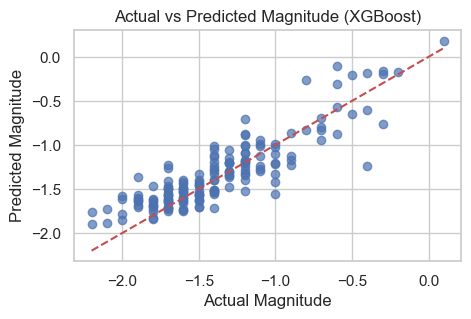

In [34]:
plt.figure(figsize=(5,3))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Magnitude (XGBoost)")
plt.grid(True)
plt.show()


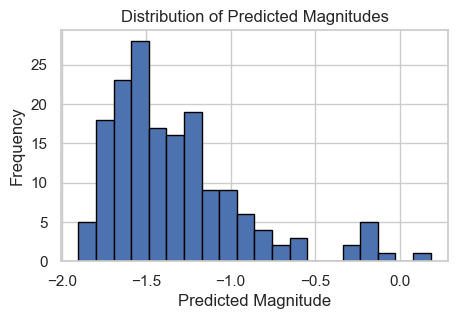

In [37]:
plt.figure(figsize=(5,3))
plt.hist(y_pred_test, bins=20, edgecolor='black')
plt.xlabel("Predicted Magnitude")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Magnitudes")
plt.show()


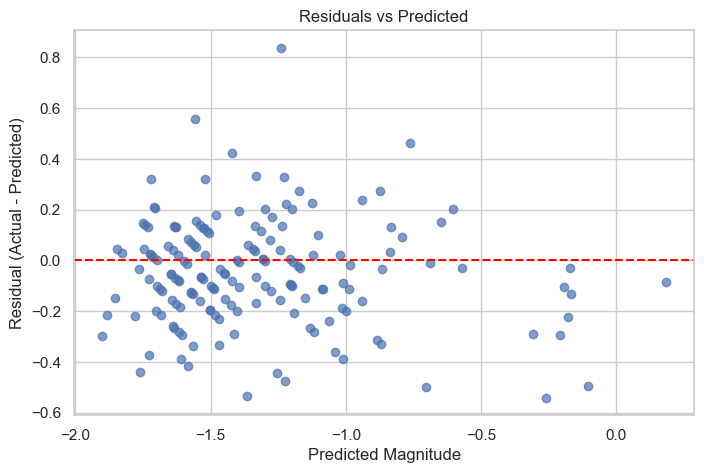

In [36]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Magnitude")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()
